In [155]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
# Import king county data from Data folder

data = pd.read_csv('Data/kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


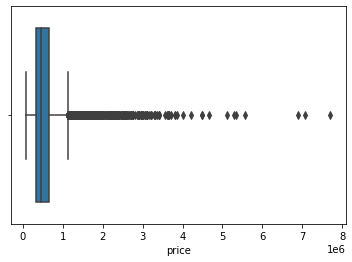

In [157]:
# The price variable looks skewed base on histogram; check distribution

fig, ax = plt.subplots()

sns.boxplot(data['price'], ax=ax);

For our purposes, we do not need to consider houses with prices greater than $1 million.

In [158]:
# drop records with price greater than $1000000

data = data.loc[ data['price'] <= 1000000 ]

In [33]:
'''Initial research on school districts'''

# to_school_district = {['Tahoma']: 'Tahoma',\
# ['Ballard', 'Nathan Hale', 'Ingraham', 'Lincoln', 'Chief Sealth','Cascade Parent Partnership Program', 'Garfield', 'Rainier Beach', 'Roosevelt', 'Franklin', 'Cleveland', 'West Seattle']: 'Seattle',\
# ['Bothell', 'Woodinville', 'Inglemoor', 'North Creek']: 'Northshore',\
# ['Kent-Meridian', 'Kentlake', 'Kentwood', 'Kentridge']: 'Kent',\
# ['Juanita', 'Eastlake', 'Emerson', 'International Community School', 'Lake Washington', 'Redmond']: 'Lake Washington',\
# ['Decatur', 'Federal Way', 'Thomas Jefferson', 'Todd Beamer']: 'Federal Way',\
# ['Lindbergh', 'Hazen', 'Renton', 'Tally']: 'Renton',\
# ['Liberty', 'Issaquah', 'Skyline', 'Echo Glen']: 'Issaquah', ['Shorecrest', 'Shorewood']: 'Shoreline',\
# ['West Auburn', 'Auburn Riverside', 'Auburn Mountainview', 'Auburn']: 'Auburn',\
# ['Mount Si', 'Two Rivers']: 'Snoqualmie Valley',\
# ['Highline', 'Evergreen', 'Mount Rainier', 'Tyee']: 'Highline', ['Enumclaw']: 'Enumclaw',\
# ['Cedarcrest']: 'Riverview', ['Mercer Island']: 'Mercer Island',\
# ['Bellevue', 'Interlake', 'Newport', 'Sammamish']: 'Bellevue',\
# ['Foster']: 'Tukwila', ['Vashon Island']: 'Vashon Island'}

TypeError: unhashable type: 'list'

## end zipcode to school district

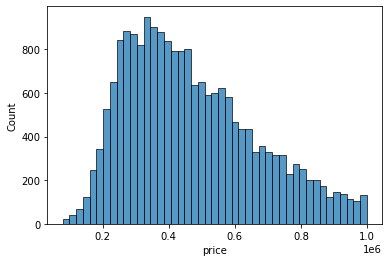

In [159]:
# re-check distribution of price

fig, ax = plt.subplots()

sns.histplot(data['price']);

Price is still skewed, but much less so.

In [160]:
# check for missing values

data.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2227
view               57
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3577
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### Waterfront

In [33]:
data.waterfront.value_counts()

NO     17862
YES       50
Name: waterfront, dtype: int64

#### View

In [34]:
data.view.value_counts()

NONE         18611
AVERAGE        763
GOOD           319
FAIR           260
EXCELLENT      129
Name: view, dtype: int64

#### Fill Null Values: Waterfront & View

In [161]:
# assume no waterfront, no view, if not specified

data.waterfront.fillna('NO', inplace=True)
data.view.fillna('NONE', inplace=True)

#### Yr_renovated

In [9]:
data.yr_renovated.value_counts()

0.0       15962
2014.0       63
2013.0       27
2000.0       25
2007.0       23
          ...  
1956.0        1
1948.0        1
1971.0        1
1953.0        1
1934.0        1
Name: yr_renovated, Length: 70, dtype: int64

#### Fill null values, engineer new feature and drop yr_renovated

In [162]:
# engineer new feature, renovated, then drop yr_renovated

# assume not renovated if not specified
data.yr_renovated.fillna(0, inplace=True)

# create renovated flag, set to true
data['renovated'] = 1
# set renovated flag to false for houses with yr_renovated value of 0
data.loc[ data['yr_renovated'] == 0, 'renovated'] = 0

# drop yr_renovated
data.drop('yr_renovated', axis=1, inplace=True)

In [6]:
# check data types

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20139 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20139 non-null  int64  
 1   date           20139 non-null  object 
 2   price          20139 non-null  float64
 3   bedrooms       20139 non-null  int64  
 4   bathrooms      20139 non-null  float64
 5   sqft_living    20139 non-null  int64  
 6   sqft_lot       20139 non-null  int64  
 7   floors         20139 non-null  float64
 8   waterfront     20139 non-null  object 
 9   view           20139 non-null  object 
 10  condition      20139 non-null  object 
 11  grade          20139 non-null  object 
 12  sqft_above     20139 non-null  int64  
 13  sqft_basement  20139 non-null  object 
 14  yr_built       20139 non-null  int64  
 15  zipcode        20139 non-null  int64  
 16  lat            20139 non-null  float64
 17  long           20139 non-null  float64
 18  sqft_l

In [12]:
data.date.head()

0    10/13/2014
1     12/9/2014
2     2/25/2015
3     12/9/2014
4     2/18/2015
Name: date, dtype: object

In [163]:
# create month feature
data['mo_sold'] = data.date.map(lambda x: x.split('/')[0])

# drop data
data.drop('date', axis=1, inplace=True)

In [164]:
# make the month a number

data.loc[:, 'mo_sold'] = data['mo_sold'].astype(int)

In [77]:
data.waterfront.value_counts()

NO     20089
YES       50
Name: waterfront, dtype: int64

In [165]:
# make waterfront feature 0 or 1 instead of no or yes

data.waterfront.replace({'NO': 0, 'YES': 1}, inplace=True)

In [79]:
data.view.value_counts()

NONE         18668
AVERAGE        763
GOOD           319
FAIR           260
EXCELLENT      129
Name: view, dtype: int64

In [166]:
# make view feature 0, 1, 2, 3 or 4 instead of none, fair, average, good, excellent

data.view.replace({'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}, inplace=True)

In [18]:
data.condition.value_counts()

Average      13076
Good          5347
Very Good     1520
Fair           168
Poor            28
Name: condition, dtype: int64

In [167]:
# make condition feature 0, 1, 2, 3 or 4 instead of poor, fair, average, good, very good

data.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)

In [168]:
# replace grade description with the numerical grade at the beginning of the string, as an int

data['grade'] = data.grade.map(lambda x: x.split(' ')[0]).astype(int)

In [21]:
data.sqft_basement.value_counts()

0.0       12282
?           424
600.0       211
500.0       206
700.0       193
          ...  
2196.0        1
2000.0        1
704.0         1
1840.0        1
20.0          1
Name: sqft_basement, Length: 266, dtype: int64

In [169]:
# replace ?s with 0 in sqft_basement, assume no basement if not specified
data.sqft_basement.replace('?', '0.0', inplace=True)

# cast to float
data['sqft_basement'] = data.sqft_basement.astype(float)

# create new feature, basement flag
data['basement'] = 1
# set flag to 0 if sqft of basement is 0
data.loc[ data['sqft_basement'] == 0, 'basement' ] = 0

# drop sqft_basement (not enough data)
data.drop('sqft_basement', axis=1, inplace=True)

Create new feature, school district, based on zipcodes and research to link zipcodes to school districts via the high school listed for a house with that zipcode on Realtor.com.

In [170]:
zipcode_to_school =\
{98038: 'Tahoma', 98103: 'Ingraham', 98052: 'Woodinville', 98115: 'Nathan Hale', 98042: 'Kentwood', 98117: 'Ingraham'\
, 98034: 'Juanita', 98118: 'Rainier Beach', 98023: 'Decatur', 98133: 'Ingraham', 98058: 'Lindbergh', 98059: 'Liberty'\
, 98155: 'Shorecrest', 98074: 'Eastlake', 98056: 'Hazen', 98125: 'Nathan Hale', 98027: 'Issaquah', 98006: 'Issaquah',\
98053: 'Redmond', 98001: 'Todd Beamer', 98126: 'Chief Sealth', 98092: 'Auburn', 98033: 'Lake Washington',\
98106: 'Chief Sealth', 98075: 'Skyline', 98144: 'Franklin', 98029: 'Skyline', 98116: 'West Seattle', 98065:\
'Mount Si', 98146: 'Highline', 98003: 'Federal Way', 98028: 'Inglemoor', 98198: 'Mount Rainier', 98031: 'Kentridge',\
98168: 'Highline', 98122: 'Garfield', 98055: 'Lindbergh', 98008: 'Issaquah', 98107: 'Ballard', 98072: 'Woodinville',\
98178: 'Renton', 98030: 'Kent-Meridian', 98199: 'Ballard', 98136: 'Chief Sealth', 98166: 'Mount Rainier', 98022:\
'Enumclaw', 98177: 'Ingraham', 98045: 'Mount Si', 98002: 'Auburn', 98011: 'Bothell', 98019: 'Cedarcrest',\
98108: 'Franklin', 98077: 'Redmond', 98105: 'Roosevelt', 98112: 'Garfield', 98040: 'Mercer Island', 98119:\
'Cascade Parent Partnership Program', 98005: 'Bellevue', 98004: 'Bellevue', 98188: 'Foster', 98007: 'Interlake',\
 98032: 'Kent-Meridian', 98014: 'Cedarcrest', 98070: 'Vashon Island', 98010: 'Enumclaw', 98109:\
'Cascade Parent Partnership Program', 98102: 'Garfield', 98024: 'Mount Si', 98148: 'Mount Rainier', 98039: 'Bellevue'}

In [171]:
# create high school column by copying zipcode column, then using replacement dictionary zipcode_to_school

data['highschool'] = data['zipcode'].copy()

data.highschool.replace(zipcode_to_school, inplace=True)

In [172]:
# create school district column by copying high school column, and replacing one district at a time

data['school_district'] = data['highschool'].copy()

to_replace = ['Ballard', 'Nathan Hale', 'Ingraham', 'Lincoln', 'Chief Sealth', 'Cascade Parent Partnership Program']
data.school_district.replace(to_replace, 'Seattle', inplace=True)

to_replace = ['Garfield', 'Rainier Beach', 'Roosevelt', 'Franklin', 'Cleveland', 'West Seattle']
data.school_district.replace(to_replace, 'Seattle', inplace=True)

to_replace = ['Bothell', 'Woodinville', 'Inglemoor', 'North Creek']
data.school_district.replace(to_replace, 'Northshore', inplace=True)

to_replace = ['Kent-Meridian', 'Kentlake', 'Kentwood', 'Kentridge']
data.school_district.replace(to_replace, 'Kent', inplace=True)

to_replace = ['Juanita', 'Eastlake', 'Emerson', 'International Community School', 'Lake Washington', 'Redmond']
data.school_district.replace(to_replace, 'Lake_Washington', inplace=True)

to_replace = ['Decatur', 'Federal Way', 'Thomas Jefferson', 'Todd Beamer']
data.school_district.replace(to_replace, 'Federal_Way', inplace=True)

to_replace = ['Lindbergh', 'Hazen', 'Renton', 'Tally']
data.school_district.replace(to_replace, 'Renton', inplace=True)

to_replace = ['Liberty', 'Issaquah', 'Skyline', 'Echo Glen']
data.school_district.replace(to_replace, 'Issaquah', inplace=True)

to_replace = ['Shorecrest', 'Shorewood']
data.school_district.replace(to_replace, 'Shoreline', inplace=True)

to_replace = ['West Auburn', 'Auburn Riverside', 'Auburn Mountainview', 'Auburn']
data.school_district.replace(to_replace, 'Auburn', inplace=True)

to_replace = ['Mount Si', 'Two Rivers']
data.school_district.replace(to_replace, 'Snoqualmie_Valley', inplace=True)

to_replace = ['Highline', 'Evergreen', 'Mount Rainier', 'Tyee']
data.school_district.replace(to_replace, 'Highline', inplace=True)

to_replace = ['Cedarcrest']
data.school_district.replace(to_replace, 'Riverview', inplace=True)

to_replace = ['Bellevue', 'Interlake', 'Newport', 'Sammamish']
data.school_district.replace(to_replace, 'Bellevue', inplace=True)

to_replace = ['Foster']
data.school_district.replace(to_replace, 'Tukwila', inplace=True)

to_replace = ['Vashon Island']
data.school_district.replace(to_replace, 'Vashon_Island', inplace=True)

to_replace = ['Mercer Island']
data.school_district.replace(to_replace, 'Mercer_Island', inplace=True)

In [173]:
data['school_district'].value_counts()

Seattle              6439
Issaquah             2103
Lake_Washington      1832
Renton               1383
Northshore           1287
Kent                 1201
Federal_Way          1138
Highline             1129
Snoqualmie_Valley     587
Tahoma                586
Auburn                550
Shoreline             440
Bellevue              423
Enumclaw              333
Riverview             310
Mercer_Island         147
Tukwila               136
Vashon_Island         115
Name: school_district, dtype: int64

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20139 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               20139 non-null  int64  
 1   price            20139 non-null  float64
 2   bedrooms         20139 non-null  int64  
 3   bathrooms        20139 non-null  float64
 4   sqft_living      20139 non-null  int64  
 5   sqft_lot         20139 non-null  int64  
 6   floors           20139 non-null  float64
 7   waterfront       20139 non-null  int64  
 8   view             20139 non-null  int64  
 9   condition        20139 non-null  int64  
 10  grade            20139 non-null  int64  
 11  sqft_above       20139 non-null  int64  
 12  yr_built         20139 non-null  int64  
 13  zipcode          20139 non-null  int64  
 14  lat              20139 non-null  float64
 15  long             20139 non-null  float64
 16  sqft_living15    20139 non-null  int64  
 17  sqft_lot15  

One Hot Encode school_district feature.

In [174]:
# one hot encode school_district

from sklearn.preprocessing import OneHotEncoder

zip_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

zip_ohe.fit(data[['school_district']])

new_school_district_cols = zip_ohe.get_feature_names(input_features=['school_district'])

data_ohe = pd.DataFrame(zip_ohe.fit_transform(data[['school_district']]), columns = new_school_district_cols,\
                          index = data.index)

data = pd.concat([data.drop('school_district', axis=1), data_ohe], axis=1)

In [175]:
abs(data.corr()['price']).sort_values(ascending=False)

price                                1.000000
grade                                0.617413
sqft_living                          0.604188
sqft_living15                        0.549455
sqft_above                           0.515646
lat                                  0.440495
bathrooms                            0.439473
bedrooms                             0.288019
floors                               0.269781
school_district_Federal_Way          0.227685
school_district_Kent                 0.215956
view                                 0.213743
school_district_Issaquah             0.204040
school_district_Lake_Washington      0.187414
school_district_Highline             0.184158
school_district_Bellevue             0.183002
school_district_Renton               0.165708
basement                             0.155946
school_district_Seattle              0.153767
school_district_Mercer_Island        0.151681
school_district_Auburn               0.144513
school_district_Northshore        

Based on prior understanding of how homes are valued, and the correlations of the above features with price, I am going to create a baseline model using grade as a feature, then add one to three features at a time which are relatively highly correlated to the price of a home and note the effect on the R2 value of the model.

## Baseline Model

In [176]:
'''Importing Necessary Libraries'''

# import statsmodels libraries

import statsmodels.api as sm
from statsmodels.formula.api import ols

# import library for train test split

from sklearn.model_selection import train_test_split

In [177]:
# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[['grade']], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# inspect all_train first five rows
all_train.head()

,grade,price
10182,7,260000.0
1722,7,350000.0
21559,8,399950.0
9145,8,898500.0
10325,8,750000.0


In [178]:
# build formula
formula = 'price ~ grade'

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     8776.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:32   Log-Likelihood:            -1.8837e+05
No. Observations:               14097   AIC:                         3.767e+05
Df Residuals:                   14095   BIC:                         3.768e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.289e+05   9644.949    -44.468      0.000   -4.48e+05    -4.1e+05
grade       1.193e+05   1273.739     93.681      0.000    1.17e+05    1.22e+05
==============================================================================
Omnibus:                      622.577   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.728
Skew:                           0.542   Prob(JB):                    3.43e-154
Kurtosis:                       3.161   Cond. No.                         57.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

My baseline model has an R2 value of 0.384, so the model already explains about 38.4% of the variance in home price.

The intercept and coefficient of my baseline model suggest that a home with exceedingly poor grade construction (even less than the lowest level assigned by the county) is -\\$44800; you would have to pay someone to buy such a poorly constructed home. As the grade increases by one level, the price of the home should increase by about \\$120000.

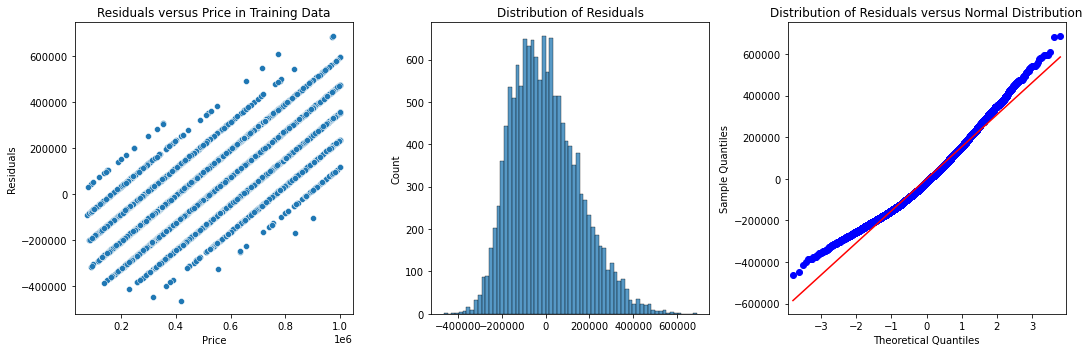

In [179]:
'''check assumptions'''

# compute residuals for training data
residuals = (y_train['price'] - model.predict(X_train)).values

# check homoscedasticity, and normality of residuals
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].set(title='Residuals versus Price in Training Data', ylabel='Residuals', xlabel='Price')
sns.scatterplot(x=y_train['price'], y=residuals, ax=ax[0])

ax[1].set_title('Distribution of Residuals')
sns.histplot(residuals, ax=ax[1])

ax[2].set_title('Distribution of Residuals versus Normal Distribution')
sm.qqplot(residuals, line='s', ax=ax[2])

fig.tight_layout();

The assumptions for linear regression are not perfectly met, as the residuals are not normally distributed -- the distribution of the residuals is positively skewed. It is possible that there are outliers in home price that are causing this skew.

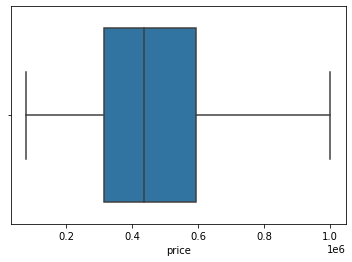

In [180]:
sns.boxplot(x=data['price']);

I am going to ignore the non-normality of the residuals for now, and try adding the next three most correlated features with price to my model.

In [181]:
# baseline model
features = ['grade']

# add next three most correlated features
for feature in ['sqft_living', 'sqft_living15', 'sqft_above']:
    features.append(feature)

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     2958.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:39   Log-Likelihood:            -1.8749e+05
No. Observations:               14097   AIC:                         3.750e+05
Df Residuals:                   14092   BIC:                         3.750e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.874e+05   1.03e+04    -27.797      0.000   -3.08e+05   -2.67e+05
grade          7.413e+04   1800.999     41.162      0.000    7.06e+04    7.77e+04
sqft_living     102.7828      3.313     31.026      0.000      96.289     109.276
sqft_living15    45.0563      3.194     14.105      0.000      38.795      51.318
sqft_above      -52.4895      3.465    -15.148      0.000     -59.281     -45.698
==============================================================================
Omnibus:                      517.776   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              575.925
Skew:                           0.484   Prob(JB):                    8.70e-126
Kurtosis:                       3.206   Cond. No.                     2.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model has an R2 of 0.456, explaining about 45.6% of the variance in home price.

The coefficient for grade is more modest now, suggesting that an increase in quality of the grade of construction by one level of ranking increases the price of the home by about \\$70000.

Sqft_living has a much smaller effect on the price of the home per unit increase (which makes sense, because an increase in square footage by only 1 sqft should not have a huge effect on the price, but cumulatively, an increase in square footage by many square feet should cause an increase in price.) On average, an increase in square footage by 1 sqft should increase the price of a home by about \\$100. Or, in a more interpretable way, every 100 sqft increase in home size should increase the price by about \\$10,000.

Sqft_living15, the average square footage of 15 neighboring homes, increases the price of the home by about \\$45 per square foot increase.

Sqft_above, surprisingly, has a *negative* effect on the price of the home as it increases. I do not believe this, so I wonder what could be causing the model to interpret it this way -- are sqft_above and sqft_living too similar, and only one needs to be included?

In [182]:
# remove sqft_above, and observe effect on R2 and model coefficients
features.remove('sqft_above')

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     3806.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:41   Log-Likelihood:            -1.8760e+05
No. Observations:               14097   AIC:                         3.752e+05
Df Residuals:                   14093   BIC:                         3.752e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.517e+05   1.01e+04    -24.803      0.000   -2.72e+05   -2.32e+05
grade          6.784e+04   1766.577     38.401      0.000    6.44e+04    7.13e+04
sqft_living      71.6246      2.618     27.359      0.000      66.493      76.756
sqft_living15    36.4283      3.169     11.497      0.000      30.218      42.639
==============================================================================
Omnibus:                      552.775   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              618.714
Skew:                           0.507   Prob(JB):                    4.45e-135
Kurtosis:                       3.158   Cond. No.                     2.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing sqft_above causes the coefficient of sqft_living to be more modest, but still positive, which I think makes sense. The R2 is slightly lowered by this choice, but I think it makes the coefficients more interpretable.

Next, I am going to add the next three most correlated features with price, SKIPPING latitude because that seems like an odd feature to include in a model for home price, and see if I can increase the R2 even more.

In [183]:
# add next three most correlated features
for feature in ['bathrooms', 'bedrooms', 'floors']:
    features.append(feature)

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     1929.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:44   Log-Likelihood:            -1.8756e+05
No. Observations:               14097   AIC:                         3.751e+05
Df Residuals:                   14090   BIC:                         3.752e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.263e+05   1.13e+04    -19.990      0.000   -2.49e+05   -2.04e+05
grade          6.926e+04   1899.121     36.467      0.000    6.55e+04     7.3e+04
sqft_living      89.9718      3.290     27.350      0.000      83.524      96.420
sqft_living15    33.8655      3.175     10.666      0.000      27.642      40.089
bathrooms     -1.702e+04   2765.249     -6.155      0.000   -2.24e+04   -1.16e+04
bedrooms      -9740.3674   1798.102     -5.417      0.000   -1.33e+04   -6215.850
floors            7.2810   2764.020      0.003      0.998   -5410.564    5425.126
==============================================================================
Omnibus:                      564.037   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.895
Skew:                           0.510   Prob(JB):                    3.70e-138
Kurtosis:                       3.195   Cond. No.                     2.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R2 value of the model increases by only 0.03; these features seem to add little predictive power to the model.

Looking at the coefficients of the model, the perceived effect of increases in grade and sqft_living on price are still comparable to that of the last model, and the effect of sqft_living15 has slightly decreased, but is still decidedly positive.

An increase in the number of bathrooms and bedrooms is interpreted as *decreasing* the value of the home which I find surprising. This suggests to me that, once again, we may be dealing with multicollinearity which the model is not able to interpret correctly in terms of which variable is influencing the price and in which direction.

The p-value and the coefficent for floors suggests that floors has very little predictive power for the home price, and the coefficient really cannot be interpreted, other than to say that, all else held equal, increasing or decreasing the number of floors does not have a consistent effect on home price. This makes sense to me, because some people may actually want a one-story home, but it is probably not a big priority for most people on the market for new houses, especially younger people, and in that case, a one story home may correlate with a smaller home which is less desirable. Whatever the case may be, I am going to drop floor from my model due to lack of explanatory power.

In [184]:
# drop floors, check effect on model
features.remove('floors')

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     2315.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:47   Log-Likelihood:            -1.8756e+05
No. Observations:               14097   AIC:                         3.751e+05
Df Residuals:                   14091   BIC:                         3.752e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.263e+05   1.13e+04    -20.004      0.000   -2.49e+05   -2.04e+05
grade          6.926e+04   1835.492     37.732      0.000    6.57e+04    7.29e+04
sqft_living      89.9711      3.280     27.431      0.000      83.542      96.400
sqft_living15    33.8650      3.171     10.680      0.000      27.650      40.080
bathrooms     -1.702e+04   2585.573     -6.582      0.000   -2.21e+04   -1.19e+04
bedrooms      -9740.6800   1794.119     -5.429      0.000   -1.33e+04   -6223.970
==============================================================================
Omnibus:                      564.033   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.889
Skew:                           0.510   Prob(JB):                    3.71e-138
Kurtosis:                       3.195   Cond. No.                     2.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking back at the list of correlations with price, and considering which features might offer different and relevant information about the price of a home, I want to experiment with adding the following features:

- **view** and **waterfront**, because they seem to add a dimension that home purchasers might feasibly care about which is different from that already encompassed by grade of construction and square footage and other size information
- **sqft_lot**, as it could encompass information about size of the property which hasn't yet been covered by indoor features
- **school_district** as this will be the only geographic location based information included in the model, and it seems that this would be important to home buyers
- **basement**, **renovated** and **yr_built** could be added as a last resort, to see if they have any significant, measurable effect on home price

I am also going to experiment with **removing** bedrooms and bathrooms since I don't buy that these would have a negative effect on home price, and I think this may be caused by multicollinearity.

In [185]:
# adding view and waterfront
for feature in ['view', 'waterfront']:
    features.append(feature)

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1738.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:50   Log-Likelihood:            -1.8740e+05
No. Observations:               14097   AIC:                         3.748e+05
Df Residuals:                   14089   BIC:                         3.749e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.285e+05   1.12e+04    -20.414      0.000    -2.5e+05   -2.07e+05
grade           6.97e+04   1815.121     38.399      0.000    6.61e+04    7.33e+04
sqft_living      86.1844      3.251     26.508      0.000      79.812      92.557
sqft_living15    29.4908      3.146      9.375      0.000      23.325      35.656
bathrooms     -1.608e+04   2557.470     -6.286      0.000   -2.11e+04   -1.11e+04
bedrooms      -7581.4530   1777.872     -4.264      0.000   -1.11e+04   -4096.589
view           3.252e+04   2092.520     15.542      0.000    2.84e+04    3.66e+04
waterfront     1.139e+05   2.57e+04      4.429      0.000    6.35e+04    1.64e+05
==============================================================================
Omnibus:                      514.974   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.676
Skew:                           0.482   Prob(JB):                    4.41e-125
Kurtosis:                       3.215   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the coefficients of this new model, having a view can increase the price of your home by \\$30,000 versus not having a view. This effect is statistically significant.

Additionally, being on a waterfront, all else held equal, increases the price of your home by anywhere from \\$63,500 to \\$164,000.

The R2 is not increasing much with the addition of new features, but the coefficients are still interpretable and statistically significant.

In [186]:
# try adding sqft_lot; does it bring new information to the model?
features.append('sqft_lot')

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1521.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:53   Log-Likelihood:            -1.8740e+05
No. Observations:               14097   AIC:                         3.748e+05
Df Residuals:                   14088   BIC:                         3.749e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.274e+05   1.12e+04    -20.290      0.000   -2.49e+05   -2.05e+05
grade          6.958e+04   1816.195     38.311      0.000     6.6e+04    7.31e+04
sqft_living      86.9164      3.277     26.524      0.000      80.493      93.340
sqft_living15    29.6933      3.147      9.434      0.000      23.524      35.863
bathrooms     -1.628e+04   2559.794     -6.359      0.000   -2.13e+04   -1.13e+04
bedrooms      -7820.0361   1782.783     -4.386      0.000   -1.13e+04   -4325.546
view           3.267e+04   2094.054     15.602      0.000    2.86e+04    3.68e+04
waterfront     1.138e+05   2.57e+04      4.425      0.000    6.34e+04    1.64e+05
sqft_lot         -0.0570      0.032     -1.780      0.075      -0.120       0.006
==============================================================================
Omnibus:                      508.814   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              565.147
Skew:                           0.479   Prob(JB):                    1.90e-123
Kurtosis:                       3.214   Cond. No.                     8.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding sqft_lot seems irrelevant; the coefficient is not statistically significant, and lies in a confidence interval containing zero, so I am going to now remove sqft_lot from the model and try adding school_district.

Additionally, this addition had no effect on the R2 (or explanatory power) of the model.

In [187]:
# remove sqft_lot; add school_district
features.remove('sqft_lot')

for school in new_school_district_cols:
    features.append(school)

# 70% / 30% train test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[['price']], test_size=0.3, random_state=421)

# concatenate X_train & y_train for statsmodels linear regression
all_train = pd.concat([X_train, y_train], axis=1)

# build formula
predictors = '+'.join(features)
formula = 'price' + ' ~ ' + predictors

# fit model using ordinary least squares
model = ols(formula=formula, data=all_train).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1586.
Date:                Sat, 12 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:38:56   Log-Likelihood:            -1.8255e+05
No. Observations:               14097   AIC:                         3.652e+05
Df Residuals:                   14072   BIC:                         3.653e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -1.509e+05   7869.495    -19.170      0.000   -1.66e+05   -1.35e+05
grade                              4.669e+04   1314.002     35.532      0.000    4.41e+04    4.93e+04
sqft_living                          95.2313      2.322     41.010      0.000      90.680      99.783
sqft_living15                        41.8930      2.383     17.583      0.000      37.223      46.563
bathrooms                         -6404.5738   1832.832     -3.494      0.000   -9997.167   -2811.981
bedrooms                          -3814.8700   1272.699     -2.997      0.003   -6309.529   -1320.211
view                               2.959e+04   1517.831     19.497      0.000    2.66e+04    3.26e+04
waterfront                         1.786e+05   1.86e+04      9.589      0.000    1.42e+05    2.15e+05
school_district_Auburn            -1.423e+05   5226.530    -27.218      0.000   -1.52e+05   -1.32e+05
school_district_Bellevue           2.185e+05   5828.297     37.483      0.000    2.07e+05     2.3e+05
school_district_Enumclaw          -9.548e+04   6345.110    -15.048      0.000   -1.08e+05    -8.3e+04
school_district_Federal_Way       -1.559e+05   3703.856    -42.089      0.000   -1.63e+05   -1.49e+05
school_district_Highline          -7.334e+04   3712.675    -19.753      0.000   -8.06e+04   -6.61e+04
school_district_Issaquah           5.756e+04   3029.296     19.001      0.000    5.16e+04    6.35e+04
school_district_Kent              -1.352e+05   3609.192    -37.450      0.000   -1.42e+05   -1.28e+05
school_district_Lake_Washington    7.861e+04   3115.470     25.232      0.000    7.25e+04    8.47e+04
school_district_Mercer_Island      2.712e+05   9525.917     28.474      0.000    2.53e+05     2.9e+05
school_district_Northshore         4.921e+04   3621.574     13.589      0.000    4.21e+04    5.63e+04
school_district_Renton            -8.035e+04   3376.006    -23.802      0.000    -8.7e+04   -7.37e+04
school_district_Riverview         -3.197e+04   6765.987     -4.724      0.000   -4.52e+04   -1.87e+04
school_district_Seattle            1.128e+05   2119.639     53.226      0.000    1.09e+05    1.17e+05
school_district_Shoreline         -1350.1327   5727.069     -0.236      0.814   -1.26e+04    9875.683
school_district_Snoqualmie_Valley -1.835e+04   4944.917     -3.710      0.000    -2.8e+04   -8653.237
school_district_Tahoma             -1.04e+05   4982.368    -20.866      0.000   -1.14e+05   -9.42e+04
school_district_Tukwila            -1.04e+05   1.01e+04    -10.343      0.000   -1.24e+05   -8.43e+04
school_district_Vashon_Island      3303.4038   1.14e+04      0.291      0.771    -1.9e+04    2.56e+04
==============================================================================
Omnibus:                      806.903   Durbin

Wow! Adding school_district increased the R2 of the model to 0.73; our model now explains 73% of the variance in home price in our data. I am satisfied with this R2 (and I think we have included all of the features that it makes sense to include at this point anyway) so I am going to work on interpreting the coefficients of the various school districts now.

- For two school districts, Vashon Island and Shoreline, the coefficients and p-values seem to indicate that the school district plays no consistent and measurable role in influencing the price of a home. The school district is really also a proxy for location in general, because it is the only geographic location based data in our model. I think that this means home prices within these areas have a higher variance than home prices in the data set in general which suggests that other features of a home are much more important in influencing the price of a home in these areas rather than location itself.

I wonder if I can programmatically access a list of the features included and their coefficients, and order the school_district features by coefficient? And perhaps analyze the distribution of the coefficients, taking into account somehow the confidence intervals thereof, to make a statement about the importance and effect of location / school_district on home price?

### Next Steps

Check assumptions for linear regression.

## Old: Using SciKit Learn

In [78]:
# import scikit learn packages needed for model building and selection

# import train_test_split and cross_validate from model_selection
from sklearn.model_selection import train_test_split, cross_validate

# import linear regression from linear_model
from sklearn.linear_model import LinearRegression

In [79]:
# Split the data 70%/30% into training and test sets
# Only use the feature grade for now, to create the baseline model
X_train, X_test, y_train, y_test = train_test_split(
    data[['grade']],
    data[['price']],
    test_size=0.3,
    random_state=421,
    shuffle=True
)

In [80]:
# sqft_living seems like a better predictor, so I am also making a baseline model with this feature to compare

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    data[['sqft_living']],
    data[['price']],
    test_size=0.3,
    random_state=421,
    shuffle=True
)

In [81]:
linreg = LinearRegression()

cross_validate(linreg, X_train, y_train, scoring='r2')['test_score']

array([0.3687176 , 0.38466712, 0.40279318, 0.37450974, 0.38410624])

In [82]:
linreg2= LinearRegression()

cross_validate(linreg2, X_train2, y_train2, scoring='r2')['test_score']

array([0.35952345, 0.35407731, 0.38769083, 0.37509904, 0.35125285])

It appears that my baseline linear model explains about 36% of the variance in home prices.

Now, checking the assumptions of linear regression:

In [83]:
# go ahead and fit the model to training data to plot regression line
linreg.fit(X_train, y_train)

LinearRegression()

In [84]:
linreg2.fit(X_train2, y_train2)

LinearRegression()

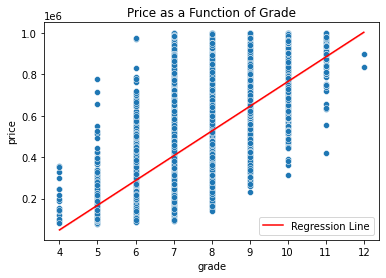

In [85]:
# Linearity

fig, ax = plt.subplots()

sns.scatterplot(x=X_train['grade'], y=y_train['price'], ax=ax)

ax.set_title('Price as a Function of Grade')

sns.lineplot(x=X_train['grade'], y=linreg.predict(X_train).reshape(-1), color='r', label='Regression Line')

ax.legend();

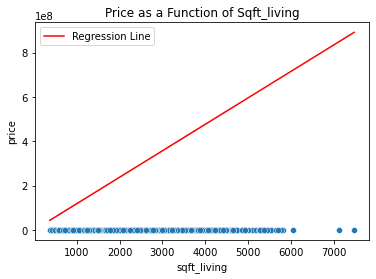

In [86]:
# Linearity (for baseline model 2)

fig, ax = plt.subplots()

sns.scatterplot(x=X_train2['sqft_living'], y=y_train2['price'], ax=ax)

ax.set_title('Price as a Function of Sqft_living')

sns.lineplot(x=X_train2['sqft_living'], y=linreg.predict(X_train2).reshape(-1), color='r', label='Regression Line')

ax.legend();

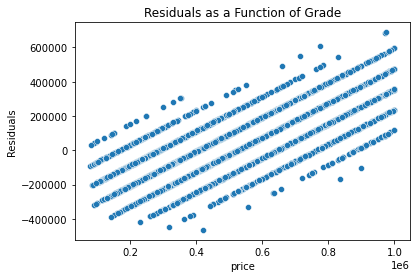

In [54]:
# Homoscedasticity & normality of residuals

residuals = y_train - linreg.predict(X_train)

fig, ax = plt.subplots()

ax.set_title('Residuals as a Function of Grade')

ax.set_ylabel('Residuals')

sns.scatterplot(x=y_train['price'], y=residuals['price']);

As price increases, the error in our model increases. This does NOT look like homoscedasticity is satisifed. Let's also check a qq plot.

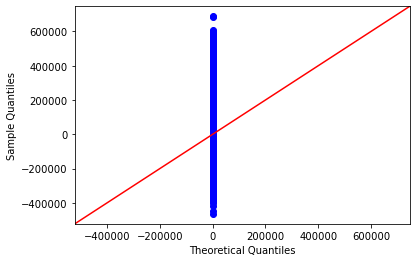

In [55]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45');

The residuals are definitely not normally distributed.

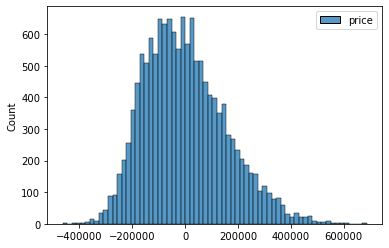

In [56]:
sns.histplot(residuals);

## Using Statsmodels

In [133]:
# import necessary packages
import statsmodels.api as sm
from statsmodels.formula.api import ols

# build the formula string
outcome = 'y_train'
predictor = 'sqft_living'
formula = outcome + '~' + predictor

# pass formula string and concatenated training data to ordinary least squares
model = ols(formula=formula, data=pd.concat([X_train,y_train], axis=1)).fit()

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.469e+04
Date:                Sun, 23 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:05:17   Log-Likelihood:            -2.1003e+05
No. Observations:               15117   AIC:                         4.201e+05
Df Residuals:                   15115   BIC:                         4.201e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.379e+04   5282.288     -8.290      0.000   -5.41e+04   -3.34e+04
sqft_living   280.8724      2.317    121.199      0.000     276.330     285.415
==============================================================================
Omnibus:                    10451.928   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           399154.274
Skew:                           2.839   Prob(JB):                         0.00
Kurtosis:                      27.525   Cond. No.                     5.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

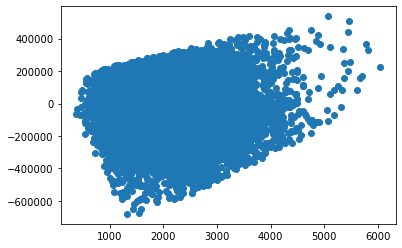

In [82]:
# checking assumptions - what do the residuals look like?

residuals = model.predict(X_train) - y_train

fig, ax = plt.subplots()

ax.scatter(X_train, residuals);

The residuals are huge! There is a little bit of a pattern in the residuals. Am I failing the normality of residuals assumption?

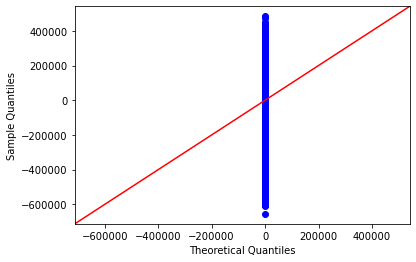

In [112]:
sm.qqplot(residuals, line='45');

Oh my goodness. The residuals are not distributed normally at all. How do I fix this?

In [86]:
# add next most correlated feature to model

features = ['sqft_living']
features.append('sqft_living15')

X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, features],
    data['price'],
    test_size=0.3,
    random_state=421,
    shuffle=True
)

In [88]:
# build the formula string
outcome = 'y_train'
predictors = X_train[features]
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

# pass formula string and concatenated training data to ordinary least squares
model = ols(formula=formula, data=pd.concat([X_train,y_train], axis=1)).fit()

# view the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     4826.
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:00:10   Log-Likelihood:            -1.9172e+05
No. Observations:               14307   AIC:                         3.834e+05
Df Residuals:                   14304   BIC:                         3.835e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.199e+04   4425.388     20.787      0.000    8.33e+04    1.01e+05
sqft_living     122.8647      2.560     47.992      0.000     117.847     127.883
sqft_living15    73.7981      3.205     23.027      0.000      67.516      80.080
==============================================================================
Omnibus:                      713.692   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              823.502
Skew:                           0.576   Prob(JB):                    1.51e-179
Kurtosis:                       3.237   Cond. No.                     9.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

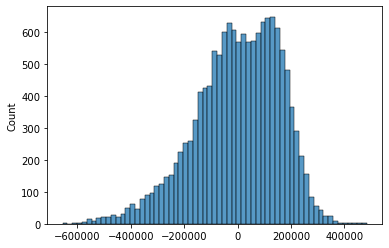

In [107]:
# the residuals LOOK normal

sns.histplot(residuals);

### One Hot Encoding

In [ ]:
# one hot encode zipcode

from sklearn.preprocessing import OneHotEncoder

zip_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

zip_ohe.fit(X_train[['zipcode']])

new_zipcode_cols = zip_ohe.get_feature_names(input_features=['zipcode'])

X_train_ohe = pd.DataFrame(zip_ohe.fit_transform(X_train[['zipcode']]), columns = new_zipcode_cols,\
                          index = X_train.index)

X_train = pd.concat([X_train.drop('zipcode', axis=1), X_train_ohe], axis=1)